In [1]:
%matplotlib inline

In [2]:
# General setup, execute this before running any other scripts
import sys
sys.path.append('..')

from tpFlow import *

# Setup output settings for notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)
import components.flowUtils
components.flowUtils.ANNOTATE_PROGRESS = False

### Displaying performance matrix

Example showing pattern of missing data in performance matrix. Items are ordered by their respective levels.

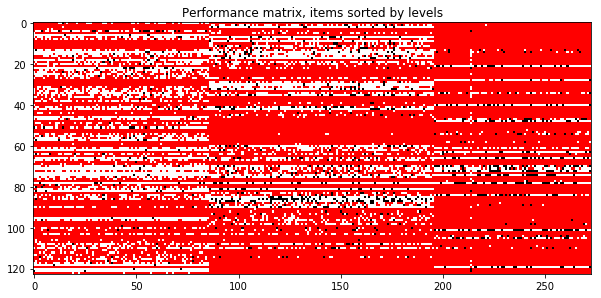

In [3]:
Flow('Performance matrix, items sorted by levels', {
    'filterProblems': filterProblemsByConcept(CONCEPTS['vyjmenovana-slova-po-b']),
    'orderProblems': lambda problem: [x for x in CONCEPTS['vyjmenovana-slova-po-b'] if x in problem['pss']][0],
    'filterUsers': lambda uid: uid > 1000000 and uid < 1200000
}, ProblemsUmime, FilterProblems, PerformanceMatrixPlot).plot()

### Item-set with large amount of possible answers
Displayed item-set has large amount of answers to items. Therefore separation by correct answer is not visible, but clusters of same level are present.

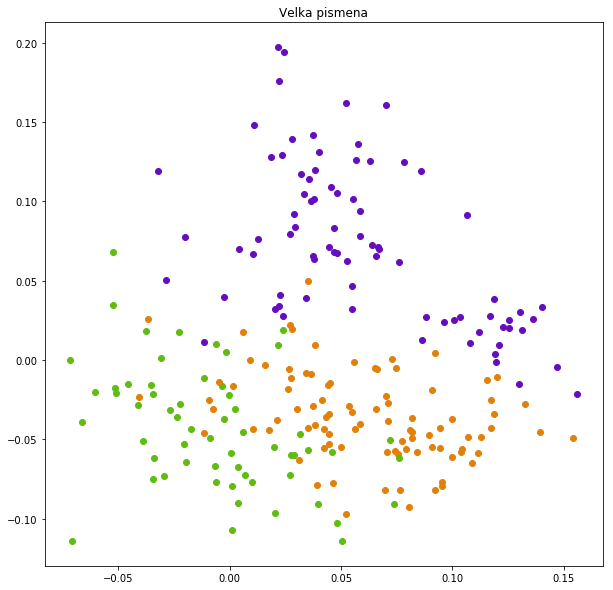

In [4]:
item_set = CONCEPTS['velka-pismena-lide-jmena']
Flow("Velka pismena", {
    'filterProblems': lambda problem: [x for x in item_set if x in problem['pss']],
    'lambdaColor': lambda problem: [COLOR_1, COLOR_2, COLOR_3][item_set.index([x for x in item_set if x in problem['pss']][0])],
    'annotate': 0.0
}, ProblemsUmime, FilterProblems, PerformanceSimilarity, LambdaProblemColor, SimilarityMatrixPCAPlot).plot()

### Simulate misssing data

Component `ProblemsSimulatedMissingAnswer` is used to simulate users answering only to some groups of questions, in this particular case there are three simulated "levels". Each user has 20% chance of continuing to another level after solving current level.

Following plots show first two and second two principal components of PCA projection.


In [5]:
simulatedMissing = Flow("Simualte missing data", {
    'questionCount': 300,
    'questionDifficulty': [0.0, 0.0, 0.0],
    'questionSkill': [0.0],
    'probabilitySolvingNextLevel': 0.2,
    'userCount': 10000
}, ProblemsSimulatedMissingAnswer, PerformanceSimilarity)

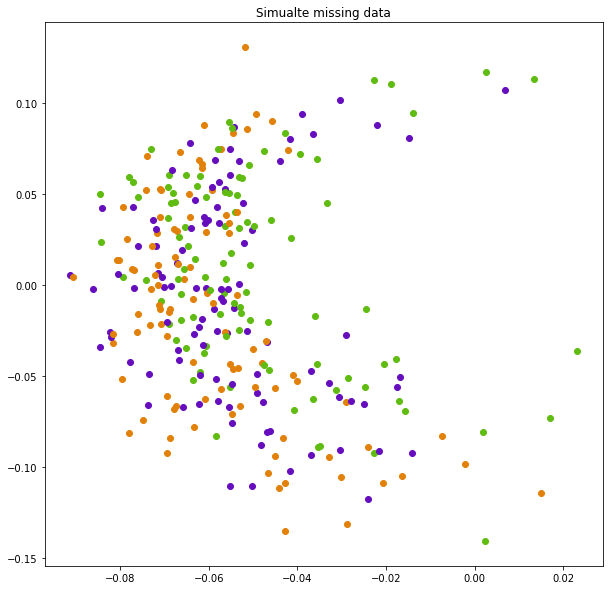

In [6]:
Flow("Simualte missing data", {
    'lambdaColor': lambda problem: [COLOR_1, COLOR_2, COLOR_3][problem['difficultyGroup']],
    'display_dimensions': (0, 1),
    'annotate': 0.0
}, simulatedMissing, LambdaProblemColor, SimilarityMatrixPCAPlot).plot()

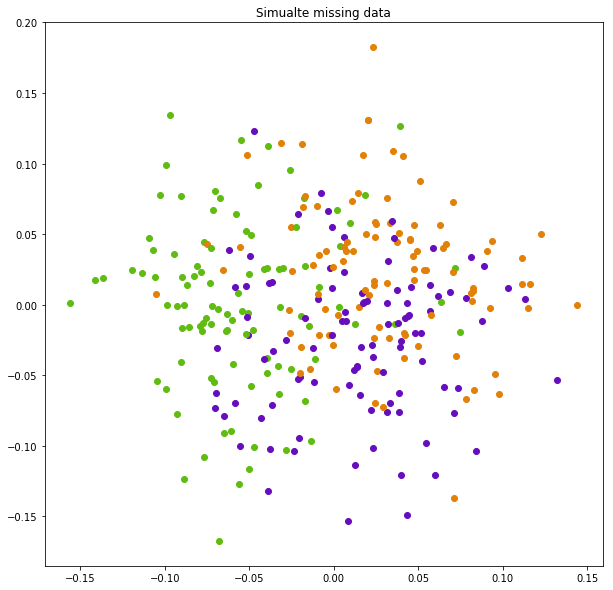

In [7]:
Flow("Simualte missing data", {
    'lambdaColor': lambda problem: [COLOR_1, COLOR_2, COLOR_3][problem['difficultyGroup']],
    'display_dimensions': (2, 3),
    'annotate': 0.0
}, simulatedMissing, LambdaProblemColor, SimilarityMatrixPCAPlot).plot()

It is visible in similarity matrix that pairs of items that are in the same level have much greater stability of results.

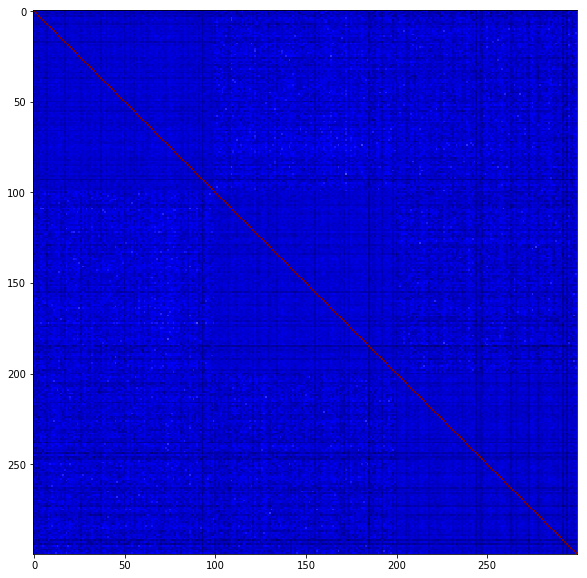

In [8]:
Flow("Similarity matrix with simulated misssing data", {
    'orderProblems': lambda problem: problem['difficultyGroup']
}, simulatedMissing, SimilarityMatrixPlot).plot()

### Altering chance of continuing to next level

Following experiment compares projections and similarity matrices for six different chances of continuing with next level.

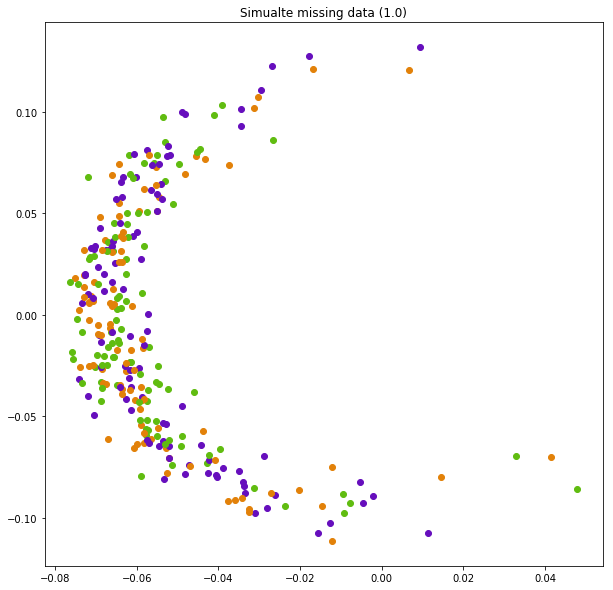

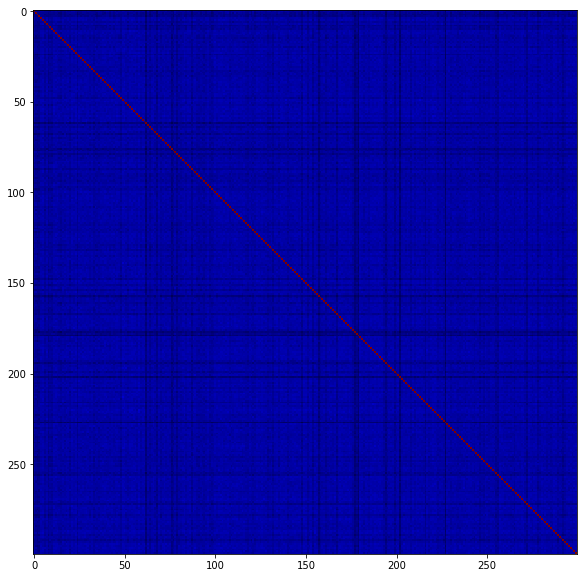

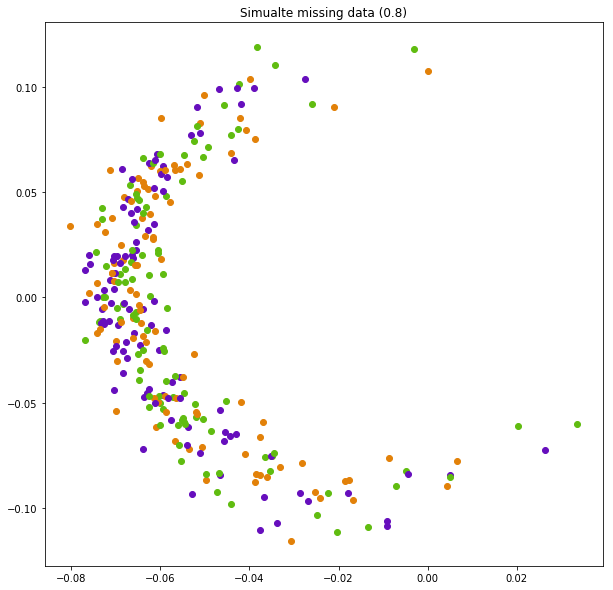

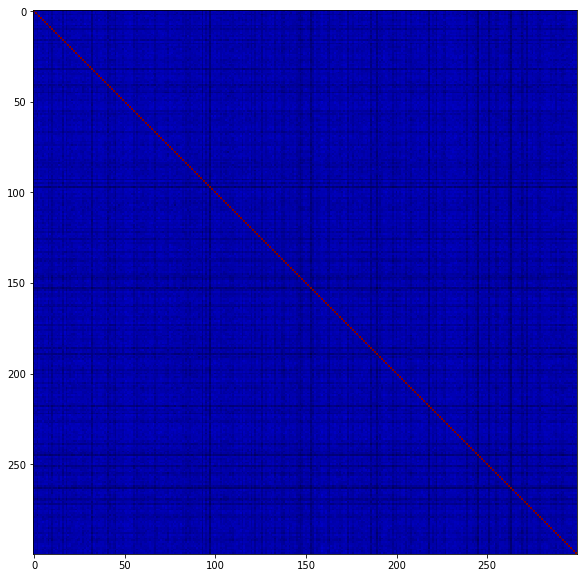

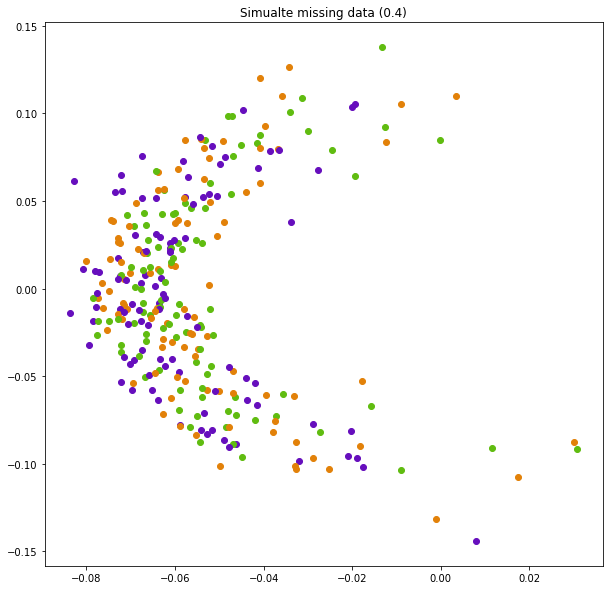

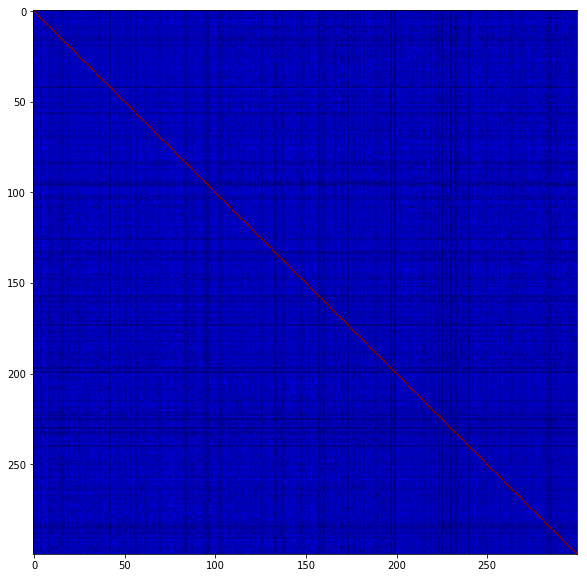

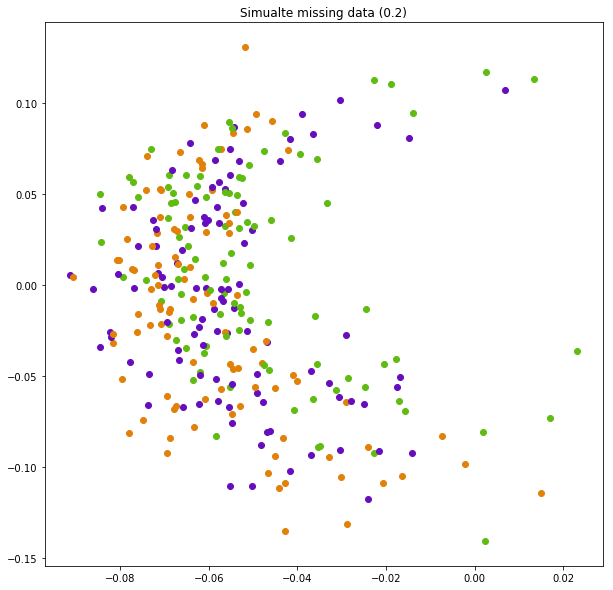

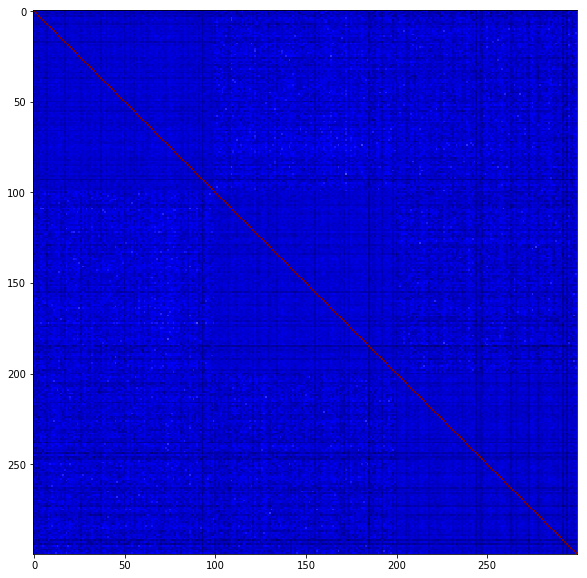

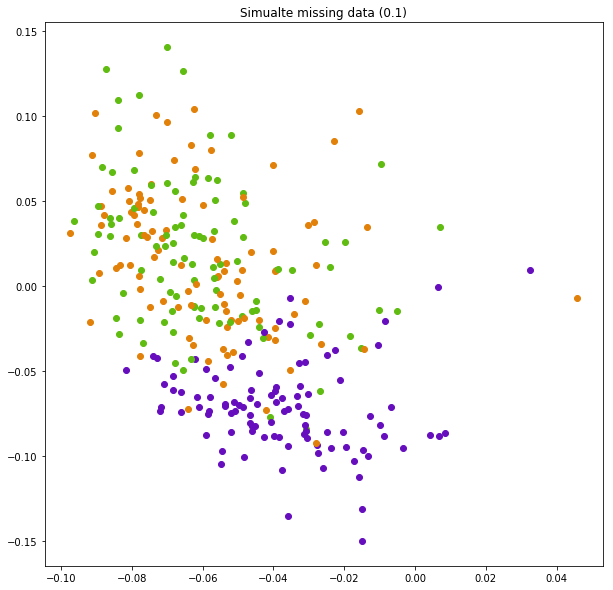

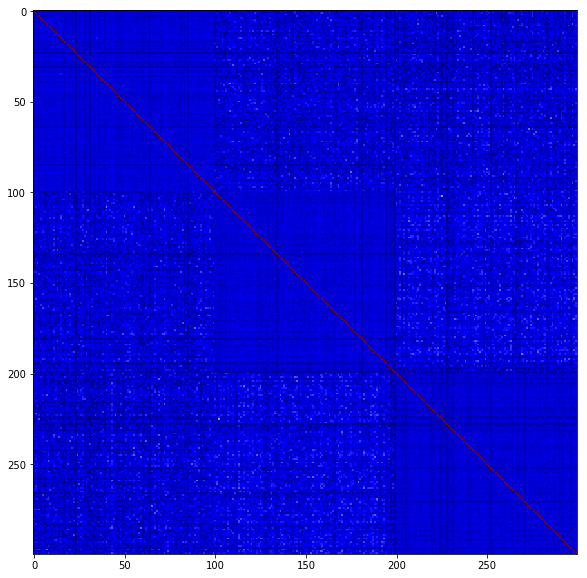

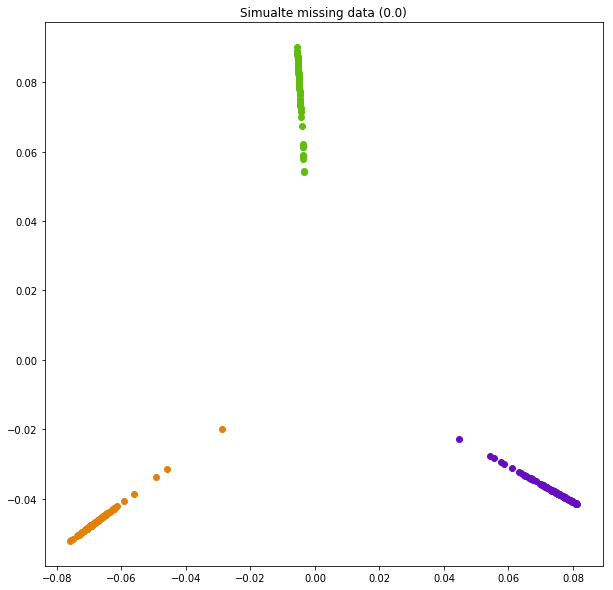

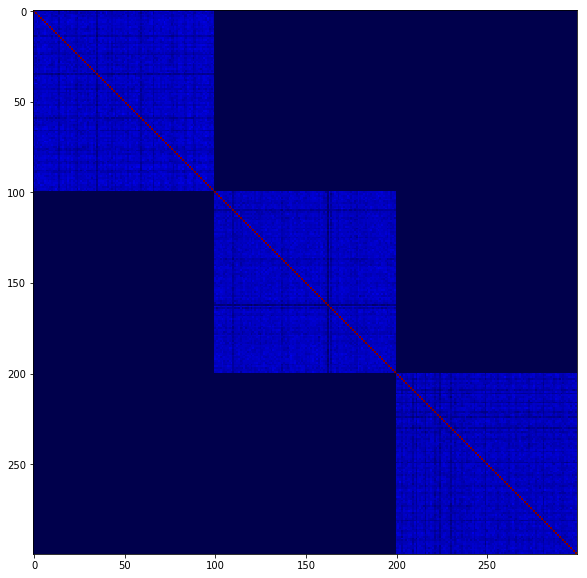

In [9]:
for p in [1.0, 0.8, 0.4, 0.2, 0.1, 0.0]:
    Flow("Simualte missing data ("+str(p)+")", {
        'questionCount': 300,
        'questionDifficulty': [0.0, 0.0, 0.0],
        'questionSkill': [0.0],
        'probabilitySolvingNextLevel': p,
        'userCount': 10000,
        'lambdaColor': lambda problem: [COLOR_1, COLOR_2, COLOR_3][problem['difficultyGroup']],
        'annotate': 0.0
    }, ProblemsSimulatedMissingAnswer, PerformanceSimilarity, LambdaProblemColor, SimilarityMatrixPCAPlot).plot()
    Flow("Simualte missing data ("+str(p)+")", {
        'questionCount': 300,
        'questionDifficulty': [0.0, 0.0, 0.0],
        'questionSkill': [0.0],
        'probabilitySolvingNextLevel': p,
        'userCount': 10000,
        'orderProblems': lambda problem: problem['difficultyGroup'],
    }, ProblemsSimulatedMissingAnswer, PerformanceSimilarity, LambdaProblemColor, SimilarityMatrixPlot).plot()

### Clustering of simualted missing data

It is visible that this regularit also affects clustering.

In [10]:
from sklearn.cluster import KMeans

conceptFlow = simulatedMissing = Flow("Simualte missing data", {
    'questionCount': 300,
    'questionDifficulty': [0.0, 0.0, 0.0],
    'questionSkill': [0.0],
    'probabilitySolvingNextLevel': 0.2,
    'userCount': 10000
}, ProblemsSimulatedMissingAnswer, PerformanceSimilarity)

problems = conceptFlow.getProblems()

problemLevel = [problem['difficultyGroup'] for pid, problem in problems.items()]

data = conceptFlow.getSimilarityMatrix()

clustersCount = 3

clustering = KMeans(n_clusters=clustersCount, init='random', n_init=1).fit_predict(data)

df = pd.DataFrame([list(problems.keys()), list(clustering), problemLevel], index=["pid", "cluster", "level"]).transpose()

In [11]:
df.groupby("cluster")["level"].value_counts().unstack(level=0)

cluster,0,1,2
level,,,
0,76,7,17
1,75,8,17
2,65,17,18


### Items performance

Both following plots show performance of items in three levels of item-set "vyjmenovana-slova-po-b".

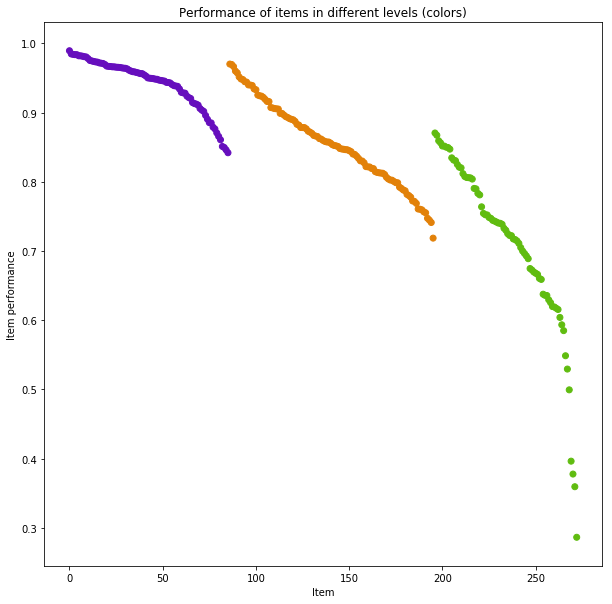

In [12]:
item_set = CONCEPTS['vyjmenovana-slova-po-b']

cestinaData = Flow('Cestina', {
    'filterProblems': filterProblemsByConcept(item_set)
}, ProblemsUmime, FilterProblems, PerformanceSimilarity, LambdaProblemColor)

problems = cestinaData.getProblems()
perfMatrix = cestinaData.getPerformanceMatrix(problems)

perfMatrix = perfMatrix.reindex(columns=sorted(perfMatrix.columns, key=lambda pid: 10 * item_set.index([x for x in item_set if x in problems[pid]['pss']][0]) - perfMatrix[pid].mean() ) )
perfSequence = perfMatrix.apply(lambda col: col.mean(), axis=0)

plt.scatter(range(len(perfSequence)), list(perfSequence), c=[ [COLOR_1, COLOR_2, COLOR_3][[383, 384, 385].index([x for x in [383, 384, 385] if x in problems[pid]['pss']][0])] for pid in list(perfMatrix) ] )
plt.xlabel("Item")
plt.ylabel("Item performance")
plt.title("Performance of items in different levels (colors)")
plt.show()

/home/ienze/git/tmsei/doodle/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


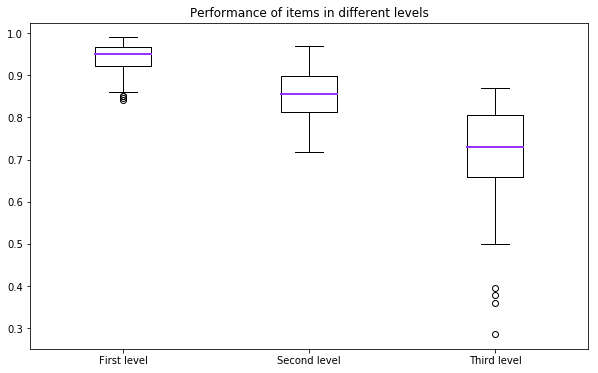

In [13]:
plt.rcParams['figure.figsize'] = (10, 6)

item_set = CONCEPTS['vyjmenovana-slova-po-b']

cestinaData = Flow('Cestina', {
    'filterProblems': filterProblemsByConcept(item_set),
    'lambdaColor': lambda problem: ['red', 'green', 'blue'][item_set.index([x for x in item_set if x in problem['pss']][0])]
}, ProblemsUmime, FilterProblems, PerformanceSimilarity, LambdaProblemColor)

problems = cestinaData.getProblems()
perfMatrix = cestinaData.getPerformanceMatrix(problems).to_dense()

problemPs = pd.Series(perfMatrix.columns, perfMatrix.columns).apply(lambda pid: item_set.index([x for x in item_set if x in problems[pid]['pss']][0]))
userLevelPerf = perfMatrix.mean()
userLevelPerfWn = [userLevelPerf[problemPs == 0], userLevelPerf[problemPs == 1], userLevelPerf[problemPs == 2]]

bp = plt.boxplot(userLevelPerfWn, labels=["First level", "Second level", "Third level"])
for median in bp['medians']:
    median.set(color='#9933ff', linewidth=2)
plt.title("Performance of items in different levels")
plt.show()

plt.rcParams['figure.figsize'] = (10, 10)

### Simulated level difficulty

Simulation with levels of different mean difficulty.

In [14]:
simFlow = Flow("Simualte item performance", {
    'questionCount': 300,
    'questionDifficulty': [1.4, 2.0, 3.0],
    'questionSkill': [0.0],
    'userCount': 10000,
}, ProblemsSimulatedMissingAnswer, PerformanceSimilarity)

problems = simFlow.getProblems()
perfMatrix = simFlow.getPerformanceMatrix(problems).to_dense()

perfMatrix.groupby(lambda pid: problems[pid]['difficultyGroup'], axis=1).mean().mean()

0    0.752037
1    0.828682
2    0.919655
dtype: float64

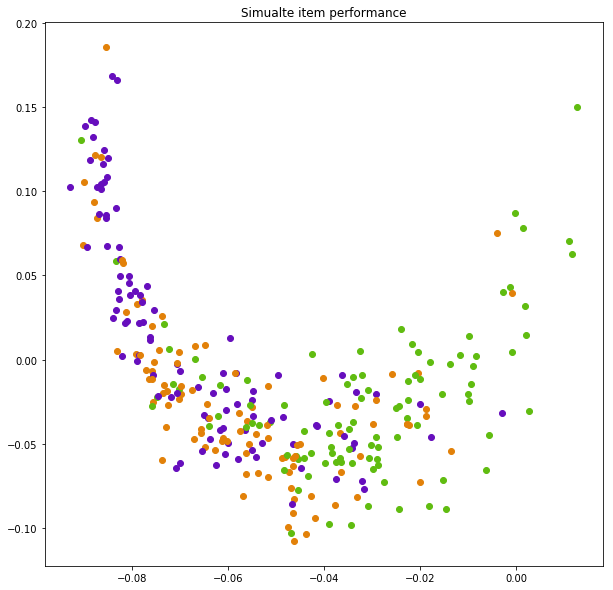

In [15]:
Flow("Simualte item performance", {
    'lambdaColor': lambda problem: [COLOR_1, COLOR_2, COLOR_3][problem['difficultyGroup']],
    'annotate': 0.0
}, simFlow, LambdaProblemColor, SimilarityMatrixPCAPlot).plot()

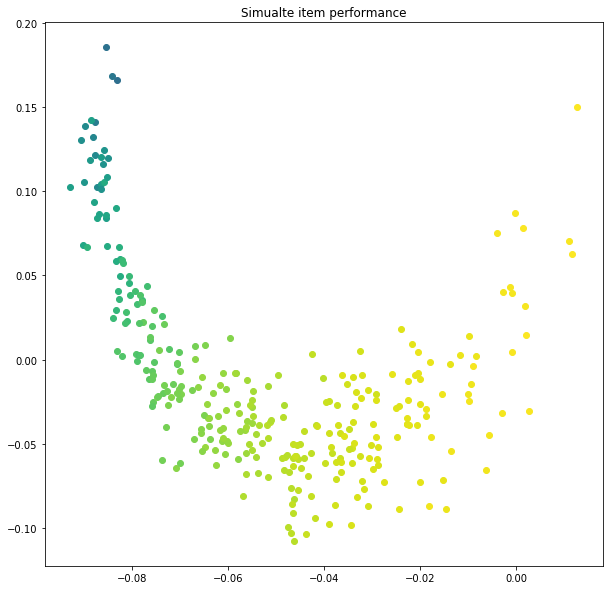

In [16]:
Flow("Simualte item performance", {
    'annotate': 0.0
}, simFlow, PerformanceColor, SimilarityMatrixPCAPlot).plot()

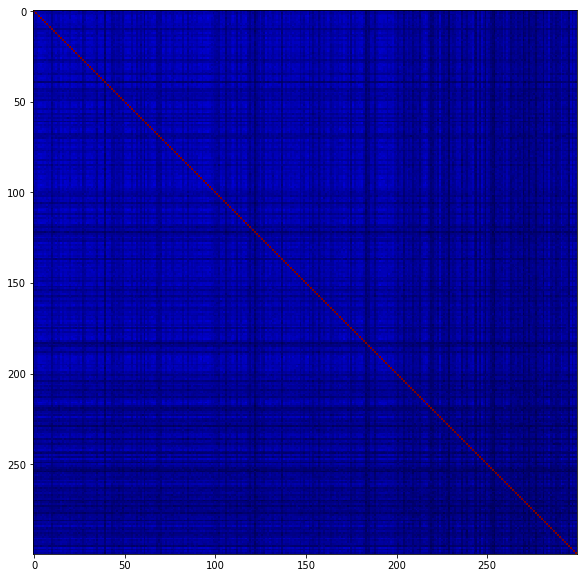

In [17]:
Flow("Simualte item performance", {
    'orderProblems': lambda problem: problem['difficultyGroup'],
}, simFlow, SimilarityMatrixPlot).plot()

### Difficulty of levels and Jaccard

Exmaple using another similarity measure. Separation of items is also slightly visble.

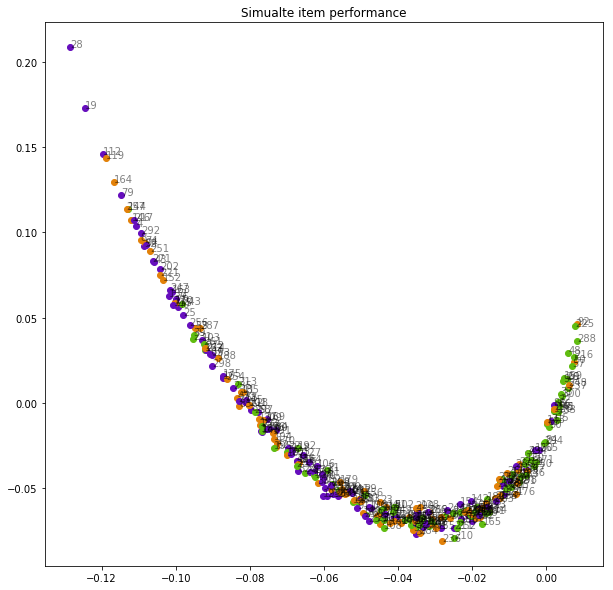

In [18]:
Flow("Simualte item performance", {
    'questionCount': 300,
    'questionDifficulty': [1.5, 2.0, 2.5],
    'questionSkill': [0.0],
    'userCount': 10000,
    'lambdaColor': lambda problem: [COLOR_1, COLOR_2, COLOR_3][problem['difficultyGroup']],
    'similarityMetric': 'jaccard'
}, ProblemsSimulatedMissingAnswer, BooleanPerformanceSimilarity, LambdaProblemColor, SimilarityMatrixPCAPlot).plot()